In [1]:
%matplotlib inline

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import numpy as np
import torch
from torch import Tensor
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm
import pandas as pd
from typing import Type
import torch
import torch.nn as nn

## Get the data

In [3]:
# fetch dataset 
# https://archive.ics.uci.edu/dataset/186/wine+quality
data = fetch_ucirepo(name='wine quality')

In [4]:
data.variables

,name,role,type,demographic,description,units,missing_values
0,fixed_acidity,Feature,Continuous,None,None,None,no
1,volatile_acidity,Feature,Continuous,None,None,None,no
2,citric_acid,Feature,Continuous,None,None,None,no
3,residual_sugar,Feature,Continuous,None,None,None,no
4,chlorides,Feature,Continuous,None,None,None,no
5,free_sulfur_dioxide,Feature,Continuous,None,None,None,no
6,total_sulfur_dioxide,Feature,Continuous,None,None,None,no
7,density,Feature,Continuous,None,None,None,no
8,pH,Feature,Continuous,None,None,None,no
9,sulphates,Feature,Continuous,None,None,None,no


In [5]:
data.data.features.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [6]:
data.data.targets.head()

,quality
0,5
1,5
2,5
3,6
4,5


<Axes: xlabel='quality', ylabel='count'>

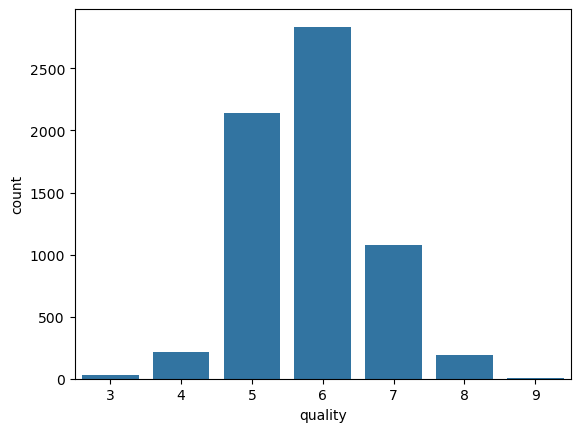

In [7]:
fig, ax = plt.subplots()
sns.countplot(data=data.data.targets, x='quality', ax=ax)

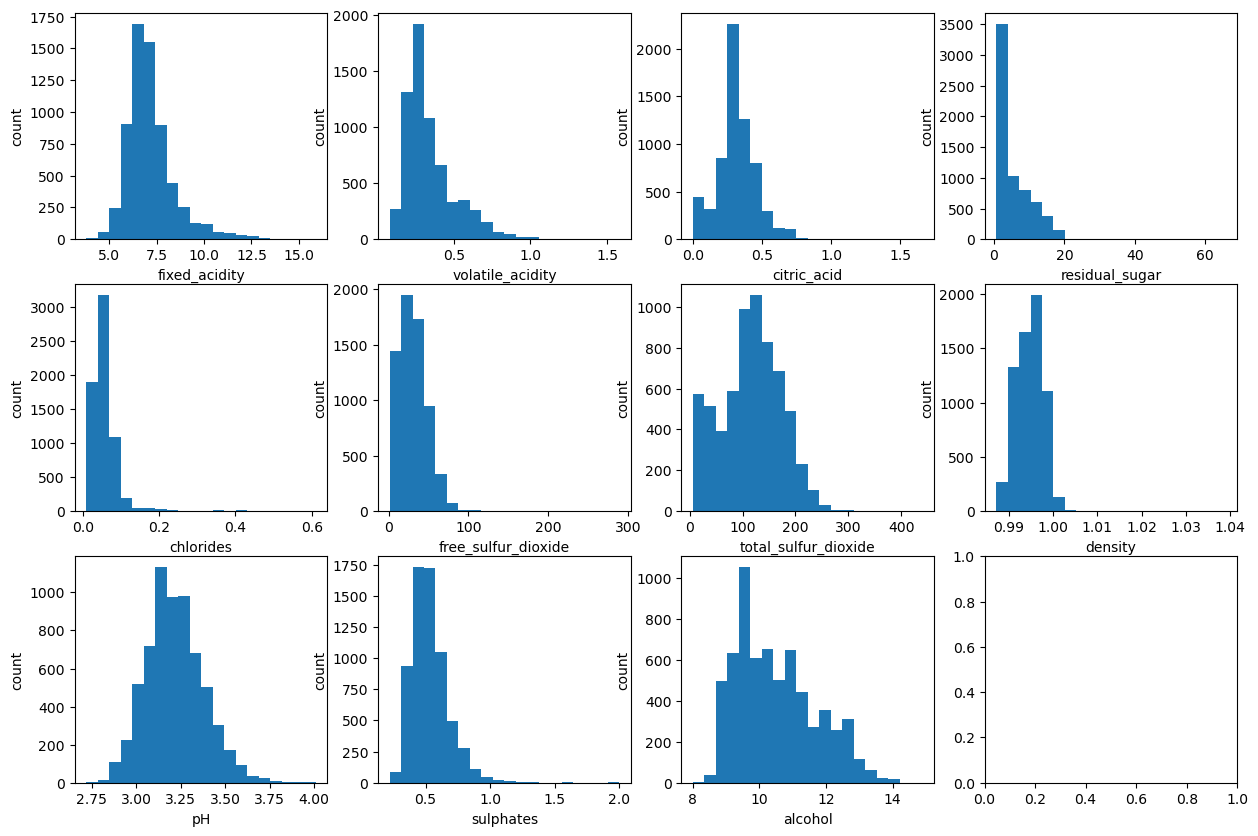

In [8]:
fig, axarr = plt.subplots(figsize=(15, 10), ncols=4, nrows=3)

for ax, column in zip(axarr.ravel(), data.data.features.columns):
    ax.hist(data.data.features[column], bins=20)
    ax.set_xlabel(column)
    ax.set_ylabel('count')

# Convert data to torch.Tensor

In [9]:
x = data.data.features.to_numpy(dtype=np.float32)
x = torch.from_numpy(x)

In [10]:
y = data.data.targets.to_numpy(dtype=np.float32)
y = torch.from_numpy(y)

## Split the dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [12]:
len(x_train), len(x_val), len(x_test)

(4157, 1040, 1300)

## Preprocessing

### Apply standardisation to inputs

In [13]:
x_mean = x_train.mean(dim=0)
x_std = x_train.std(dim=0)
for name, mean, std in zip(data.data.features.columns, x_mean, x_std):
    print(f'{name: >20s}: {mean=: >7.3f}, {std=: >6.3f}')

       fixed_acidity: mean=  7.207, std= 1.302
    volatile_acidity: mean=  0.340, std= 0.166
         citric_acid: mean=  0.321, std= 0.147
      residual_sugar: mean=  5.424, std= 4.687
           chlorides: mean=  0.056, std= 0.035
 free_sulfur_dioxide: mean= 30.547, std=17.863
total_sulfur_dioxide: mean=116.251, std=55.943
             density: mean=  0.995, std= 0.003
                  pH: mean=  3.220, std= 0.160
           sulphates: mean=  0.532, std= 0.149
             alcohol: mean= 10.483, std= 1.189


In [14]:
x_train = (x_train - x_mean) / x_std
x_val = (x_val - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

### Apply min-max scaling to targets

In [15]:
y_min = y.min(dim=0).values
y_max = y.max(dim=0).values
y_range = (y_max - y_min)

In [16]:
y_train = (y_train - y_min) / y_range
y_val = (y_val - y_min) / y_range
y_test = (y_test - y_min) / y_range

## Dataset

In [17]:
train_set = TensorDataset(x_train, y_train)
val_set = TensorDataset(x_val, y_val)
test_set = TensorDataset(x_test, y_test)

# Model

In [18]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
    ):
        """
        """
        super().__init__()

        hidden_dim_0 = 64
        hidden_dim_1 = 64
        
        # 1st hidden layer
        ## affine transformation
        self.linear_0 = nn.Linear(input_dim, hidden_dim_0, bias=True)
        ## activation
        self.act_0 = nn.ReLU()

        # 2nd hidden layer
        ## affine transformation
        self.linear_1 = nn.Linear(hidden_dim_0, hidden_dim_1, bias=True)
        ## activation
        self.act_1 = nn.ReLU()

        # output layer
        ## affine transformation
        self.linear_2 = nn.Linear(hidden_dim_1, output_dim, bias=True)


    def forward(self, input: Tensor) -> Tensor:
        """
        Args:
            input: a flaot32 Tensor
        Returns:
            output: a float32 Tensor
        Shape:
            input: (N, D_in), where N denotes batch size and D_in denotes `input_dim`
            output: (N, D_out), where D_out denotes `output_dim`
        """
        # alias 
        x = input
        
        h = self.linear_0(x)
        h = self.act_0(h)
        h = self.linear_1(h)
        h = self.act_1(h)
        h = self.linear_2(h)
        return h

In [74]:
# or we can use a simpler API
model = nn.Sequential(
    nn.Linear(11, 64, bias=True),
    nn.ReLU(),
    nn.Linear(64, 64, bias=True),
    nn.ReLU(),
    nn.Linear(64, 1, bias=True)
)

In [75]:
model

Sequential(
  (0): Linear(in_features=11, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [76]:
for name, parameter in model.named_parameters():
    shape = tuple(parameter.shape)
    print(f'{name: >20s}: {shape=}, {parameter.dtype}, {parameter.device}')

            0.weight: shape=(64, 11), torch.float32, cpu
              0.bias: shape=(64,), torch.float32, cpu
            2.weight: shape=(64, 64), torch.float32, cpu
              2.bias: shape=(64,), torch.float32, cpu
            4.weight: shape=(1, 64), torch.float32, cpu
              4.bias: shape=(1,), torch.float32, cpu


In [77]:
num_parameters = sum(each.numel() for each in model.parameters())
print(f'{num_parameters=:_d}')

num_parameters=4_993


In [78]:
optimizer = SGD(
    params=model.parameters(),
    lr=1e-3
)

In [79]:
criterion = nn.MSELoss()

In [80]:
optimizer = SGD(
    params=model.parameters(),
    lr=1e-3
)

In [81]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True, # to do "stochastic" gradient descent
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False
)

In [82]:
min_val_loss = float('inf')

train_curve: list[dict[str, float]] = []
val_curve: list[dict[str, float]] = []


global_step = 0
num_epochs = 10
for epoch in range(num_epochs + 1):
    print(f'{epoch=}')

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            y_score = model(x)
            loss = criterion(input=y_score, target=y_true)
            val_loss += loss.item()
        # divide 
    val_loss /= len(val_loader)
    
    val_curve.append({
        'step': global_step,
        'loss': val_loss,
    })
    

    if epoch >= 1:
        model.train()
        for batch in train_loader:
            x, y_true = batch
        
            optimizer.zero_grad()
            y_score = model(x)
            loss = criterion(input=y_score, target=y_true) 
    
            # magic here
            loss.backward()
            optimizer.step()
    
            global_step += 1
            train_curve.append({
                'step': global_step,
                'loss': loss.item()
            })

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10


In [83]:
train_curve = pd.DataFrame(train_curve)
val_curve = pd.DataFrame(val_curve)

Text(0, 0.5, 'MSELoss')

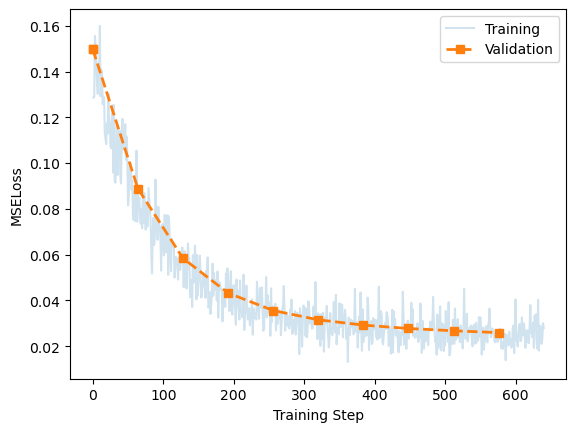

In [84]:
fig, ax = plt.subplots()
ax.plot(train_curve['step'], train_curve['loss'], label='Training', alpha=0.2)
ax.plot(val_curve['step'], val_curve['loss'], label='Validation', marker='s', ls='--', lw=2)
ax.legend()
ax.set_xlabel('Training Step')
ax.set_ylabel(criterion.__class__.__name__)